In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from folium import Map, Circle, Marker, Icon
from random import randint
from shapely.geometry import Point

In [2]:
boston_df = pd.read_csv('boston_corrected_corrected.csv')
boston_gdf  = gpd.GeoDataFrame(boston_df, geometry=gpd.points_from_xy(boston_df.LAT, boston_df.LON))

hospital_df = pd.read_csv('massachusetts-hospitals.csv')
hospital_gdf  = gpd.GeoDataFrame(hospital_df, geometry=gpd.points_from_xy(hospital_df.SHAPE_Y, hospital_df.SHAPE_X))

school_df = pd.read_csv('massachusetts-schools-pre-k-through-high-school_new.csv')
school_gdf  = gpd.GeoDataFrame(school_df, geometry=gpd.points_from_xy(school_df.SHAPE_Y, school_df.SHAPE_X))

uni_gdf = gpd.read_file('University_data\GISDATA_COLLEGES_PTPoint.shp')
uni_gdf = uni_gdf.geometry
uni_gdf = uni_gdf.apply(lambda row: Point(row.y, row.x))

train_gdf = gpd.read_file('Train_data\GISDATA_TRAINS_NODEPoint.shp')
train_gdf = train_gdf.geometry
train_gdf = train_gdf.apply(lambda row: Point(row.y, row.x))

chc_gdf = gpd.read_file('Community_Health_Center_data\GISDATA_CHCS_PTPoint.shp')
chc_gdf = chc_gdf.geometry
chc_gdf = chc_gdf.apply(lambda row: Point(row.y, row.x))

boston_gdf.set_crs(epsg=4326, inplace=True)
hospital_gdf.set_crs(epsg=4326, inplace=True)
school_gdf.set_crs(epsg=4326, inplace=True)

boston_gdf = boston_gdf.to_crs(epsg=900913) # 3857
hospital_gdf = hospital_gdf.to_crs(epsg=900913)
school_gdf = school_gdf.to_crs(epsg=900913)
uni_gdf = uni_gdf.to_crs(epsg=900913)
train_gdf = train_gdf.to_crs(epsg=900913)
chc_gdf = chc_gdf.to_crs(epsg=900913)

## Checking and cleaning the data

This data frame contains the following columns:

* TOWN a factor with levels given by town names
    * Should all be strings
    * All have capital letter at the beginning of each word

* TOWNNO a numeric vector corresponding to TOWN
    * Should be int
    * Should be same number as number of unique town names

* TRACT a numeric vector of tract ID numbers
    * Should be int
    * Should be >= 0

* LON a numeric vector of tract point longitudes in decimal degrees
    * Should be float
    * Should be between -180 and 180

* LAT a numeric vector of tract point latitudes in decimal degrees
    * Should be float
    * Should be between -90 and 90

* MEDV a numeric vector of median values of owner-occupied housing in USD 1000
    * Should be float

* CMEDV a numeric vector of corrected median values of owner-occupied housing in USD 1000
    * Should be float

* CRIM a numeric vector of per capita crime
    * Should be float

* ZN a numeric vector of proportions of residential land zoned for lots over 25000 sq. ft per town (constant for all Boston tracts)
    * Should be float

* INDUS a numeric vector of proportions of non-retail business acres per town (constant for all Boston tracts)
    * Should be float

* CHAS a factor with levels 1 if tract borders Charles River; 0 otherwise
    * Should be int

* NOX a numeric vector of nitric oxides concentration (parts per 10 million) per town
    * Should be float

* RM a numeric vector of average numbers of rooms per dwelling
    * Should be float

* AGE a numeric vector of proportions of owner-occupied units built prior to 1940
    * Should be float

* DIS a numeric vector of weighted distances to five Boston employment centres
    * Should be float

* RAD a numeric vector of an index of accessibility to radial highways per town (constant for all Boston tracts)
    * Should be float

* TAX a numeric vector full-value property-tax rate per USD 10,000 per town (constant for all Boston tracts)
    * Should be float

* PTRATIO a numeric vector of pupil-teacher ratios per town (constant for all Boston tracts)
    * Should be float

* B a numeric vector of 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks
    * Should be float

* LSTAT a numeric vector of percentage values of lower status population
    * Should be float

Adapted from: https://nowosad.github.io/spData/reference/boston.html

### Checking that there are no null values and that dtypes are as expected

In [3]:
boston_gdf.head()

Unnamed: 0        TOWN  TOWNNO  TRACT        LON        LAT  MEDV  CMEDV  \
0           0      Nahant       0   2011 -70.927800  42.426000  24.0   24.0   
1           1  Swampscott       1   2021 -70.919764  42.481455  21.6   21.6   
2           2  Swampscott       1   2022 -70.897264  42.473777  34.7   34.7   
3           3  Marblehead       2   2031 -70.884407  42.490840  33.4   33.4   
4           4  Marblehead       2   2032 -70.874764  42.499371  36.2   36.2   

      CRIM    ZN  ...    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO       B  \
0  0.00632  18.0  ...  0.538  6.575  65.2  4.0900    1  296     15.3  396.90   
1  0.02731   0.0  ...  0.469  6.421  78.9  4.9671    2  242     17.8  396.90   
2  0.02729   0.0  ...  0.469  7.185  61.1  4.9671    2  242     17.8  392.83   
3  0.03237   0.0  ...  0.458  6.998  45.8  6.0622    3  222     18.7  394.63   
4  0.06905   0.0  ...  0.458  7.147  54.2  6.0622    3  222     18.7  396.90   

   LSTAT                           geometry  
0   4.98  POINT (4722840.716 -11377630.320)  
1   9.14  POINT (4729013.939 -11374893.260)  
2   4.03  POINT (4728159.185 -11367235.395)  
3   2.94  POINT (4730058.638 -11362863.369)  
4   5.33  POINT (4731008.364 -11359586.207)  

[5 rows x 22 columns]

In [4]:
hospital_gdf = hospital_gdf.geometry
hospital_gdf.head()

0    POINT (4747466.578 -11520167.009)
1    POINT (4726668.629 -11423315.492)
2    POINT (4690267.283 -11585327.833)
3    POINT (4703181.401 -11678411.837)
4    POINT (4713250.615 -11438366.700)
Name: geometry, dtype: geometry

In [5]:
school_gdf = school_gdf.geometry
school_gdf.head()

0    POINT (4636965.302 -11379009.899)
1    POINT (4683594.326 -11989720.535)
2    POINT (4678235.601 -11478672.516)
3    POINT (4722150.287 -11409416.711)
4    POINT (4719271.669 -11414830.330)
Name: geometry, dtype: geometry

In [6]:
uni_gdf.head()

0    POINT (4688963.487 -11974293.409)
1    POINT (4690322.055 -11737696.573)
2    POINT (4690165.217 -12046083.251)
3    POINT (4691105.651 -11951920.520)
4    POINT (4691191.197 -11973019.927)
Name: geometry, dtype: geometry

In [7]:
train_gdf.head()

0    POINT (4656409.119 -11545086.256)
1    POINT (4644960.832 -11555266.180)
2    POINT (4766385.674 -11441276.682)
3    POINT (4762342.543 -11432706.794)
4    POINT (4690906.409 -11580898.730)
Name: geometry, dtype: geometry

In [8]:
chc_gdf.head()

0    POINT (4752170.841 -11453943.454)
1    POINT (4714155.422 -11424506.661)
2    POINT (4696904.504 -12263057.239)
3    POINT (4714657.473 -11424050.416)
4    POINT (4645848.910 -11445585.258)
Name: geometry, dtype: geometry

In [9]:
boston_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  506 non-null    int64   
 1   TOWN        506 non-null    object  
 2   TOWNNO      506 non-null    int64   
 3   TRACT       506 non-null    int64   
 4   LON         506 non-null    float64 
 5   LAT         506 non-null    float64 
 6   MEDV        506 non-null    float64 
 7   CMEDV       506 non-null    float64 
 8   CRIM        506 non-null    float64 
 9   ZN          506 non-null    float64 
 10  INDUS       506 non-null    float64 
 11  CHAS        506 non-null    int64   
 12  NOX         506 non-null    float64 
 13  RM          506 non-null    float64 
 14  AGE         506 non-null    float64 
 15  DIS         506 non-null    float64 
 16  RAD         506 non-null    int64   
 17  TAX         506 non-null    int64   
 18  PTRATIO     506 non-null    float64 
 19  

In [10]:
sorted(boston_gdf.TOWN.unique())

['Arlington',
 'Ashland',
 'Bedford',
 'Belmont',
 'Beverly',
 'Boston Allston-Brighton',
 'Boston Back Bay',
 'Boston Beacon Hill',
 'Boston Charlestown',
 'Boston Dorchester',
 'Boston Downtown',
 'Boston East Boston',
 'Boston Forest Hills',
 'Boston Hyde Park',
 'Boston Mattapan',
 'Boston North End',
 'Boston Roxbury',
 'Boston Savin Hill',
 'Boston South Boston',
 'Boston West Roxbury',
 'Braintree',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Chelsea',
 'Cohasset',
 'Concord',
 'Danvers',
 'Dedham',
 'Dover',
 'Duxbury',
 'Everett',
 'Framingham',
 'Hamilton',
 'Hanover',
 'Hingham',
 'Holbrook',
 'Hull',
 'Lexington',
 'Lincoln',
 'Lynn',
 'Lynnfield',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marshfield',
 'Medfield',
 'Medford',
 'Melrose',
 'Middleton',
 'Millis',
 'Milton',
 'Nahant',
 'Natick',
 'Needham',
 'Newton',
 'Norfolk',
 'North Reading',
 'Norwell',
 'Norwood',
 'Peabody',
 'Pembroke',
 'Quincy',
 'Randolph',
 'Reading',
 'Revere',
 'Rockland',
 'Sale

### Check that the characteristics of each column are as expected as defined above

In [11]:
assert len(boston_gdf.TOWN.unique()) == len(boston_gdf.TOWNNO.unique()), 'Number of unique town names must be equal to number of unique town numbers'
assert all(boston_gdf.TRACT) >= 0, 'ID numbers must be greater than or equal to zero'
assert -180 <= all(boston_gdf.LON) <= 180, 'Longitude must be between -180 and 180'
assert -90 <= all(boston_gdf.LAT) <= 90, 'Latitude must be between -90 and 90'

### Dropping the MEDV column as CMEDV will be used as our target variable and we do not want data leakage

In [12]:
boston_gdf.drop('MEDV', axis=1, inplace=True)

### Dropping TOWN because it repeats information in TOWNNO

In [13]:
boston_gdf.drop('TOWN', axis=1, inplace=True)

## Feature engineering

In [14]:
# Create a map
print('INITIALIZING MAP')
m_2 = Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)
print('MAP INITIALIZED')

boston_4326 = boston_gdf.to_crs(epsg=4326)
hospital_4326 = hospital_gdf.to_crs(epsg=4326)
school_4326 = school_gdf.to_crs(epsg=4326)
uni_4326 = uni_gdf.to_crs(epsg=4326)
train_4326 = train_gdf.to_crs(epsg=4326)
chc_4326 = chc_gdf.to_crs(epsg=4326)

colors = []
for _ in range(boston_gdf['TOWNNO'].nunique()):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

print('ADDING HOUSES TO MAP')
for i in range(len(boston_gdf)):
    if i == 8:
        Circle(
            location=[boston_gdf.iloc[i]['LAT'], boston_gdf.iloc[i]['LON']],
            radius=1000,
            color=colors[boston_gdf.iloc[i]['TOWNNO']],
            popup='House '+str(i)+'\n'+str(boston_4326.geometry.iloc[i])).add_to(m_2)
    else:
        Circle(
            location=[boston_gdf.iloc[i]['LAT'], boston_gdf.iloc[i]['LON']],
            radius=10,
            color=colors[boston_gdf.iloc[i]['TOWNNO']],
            popup='House '+str(i)+'\n'+str(boston_4326.geometry.iloc[i])).add_to(m_2)
print('COMPLETE')

print('ADDING HOSPITALS TO MAP')
for i in range(len(hospital_gdf)):
    Marker(
        location=[hospital_4326.iloc[i].x, hospital_4326.iloc[i].y],
        popup = 'Hospital',
        icon=Icon(color="red",icon="h-square", prefix='fa')).add_to(m_2)
print('COMPLETE')
    
print('ADDING SCHOOLS TO MAP')
for i in range(len(school_gdf)):
    Marker(
        location=[school_4326.iloc[i].x, school_4326.iloc[i].y],
        popup='School',
        icon=Icon(color="blue",icon="graduation-cap", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING UNIVERSITIES TO MAP')
for i in range(len(uni_gdf)):
    Marker(
        location=[uni_4326.iloc[i].x, uni_4326.iloc[i].y],
        popup='University',
        icon=Icon(color="black",icon="graduation-cap", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING TRAIN STATIONS TO MAP')
for i in range(len(train_gdf)):
    Marker(
        location=[train_4326.iloc[i].x, train_4326.iloc[i].y],
        popup='Train station',
        icon=Icon(color="green",icon="train", prefix='fa')).add_to(m_2)  
print('COMPLETE')

print('ADDING HEALTH CENTRES TO MAP')
for i in range(len(chc_gdf)):
    Marker(
        location=[chc_4326.iloc[i].x, chc_4326.iloc[i].y],
        popup='Health Centre',
        icon=Icon(color="orange",icon="medkit", prefix='fa')).add_to(m_2)  
print('COMPLETE')
    
m_2

INITIALIZING MAP
MAP INITIALIZED
ADDING HOUSES TO MAP
COMPLETE
ADDING HOSPITALS TO MAP
COMPLETE
ADDING SCHOOLS TO MAP
COMPLETE
ADDING UNIVERSITIES TO MAP
COMPLETE
ADDING TRAIN STATIONS TO MAP
COMPLETE
ADDING HEALTH CENTRES TO MAP
COMPLETE


In [15]:
print('CALCULATING DISTANCES TO NEAREST HOSPITALS')
boston_gdf['dist_nearest_hospital'] = [np.inf for _ in range(len(boston_gdf))]
for hospital in hospital_gdf:
    boston_gdf['dist_nearest_hospital'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_hospital'],
                                              boston_gdf.geometry.distance(hospital))]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST SCHOOLS')
boston_gdf['dist_nearest_school'] = [np.inf for _ in range(len(boston_gdf))]
for school in school_gdf:
    dist_to_school = boston_gdf.geometry.apply(lambda x: school.distance(x))
    boston_gdf['dist_nearest_school'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_school'], dist_to_school)]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST UNIVERSITIES')    
boston_gdf['dist_nearest_uni'] = [np.inf for _ in range(len(boston_gdf))]
for uni in uni_gdf:
    dist_to_uni = boston_gdf.geometry.apply(lambda x: uni.distance(x))
    boston_gdf['dist_nearest_uni'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_uni'], dist_to_uni)]
print('COMPLETE')
print('CALCULATING DISTANCES TO NEAREST TRAIN STATIONS')
boston_gdf['dist_nearest_train_station'] = [np.inf for _ in range(len(boston_gdf))]
for train in train_gdf:
    dist_to_train_station = boston_gdf.geometry.apply(lambda x: train.distance(x))
    boston_gdf['dist_nearest_train_station'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_train_station'], 
                                                                        dist_to_train_station)]
print('COMPLETE')
boston_gdf['dist_nearest_health_centre'] = [np.inf for _ in range(len(boston_gdf))]
print('CALCULATING DISTANCES TO NEAREST HEALTH CENTRES')
for chc in chc_gdf:
    dist_to_chc = boston_gdf.geometry.apply(lambda x: chc.distance(x))
    boston_gdf['dist_nearest_health_centre'] = [min(a,b) for a,b in zip(boston_gdf['dist_nearest_health_centre'], 
                                                                        dist_to_chc)]
print('COMPLETE')

CALCULATING DISTANCES TO NEAREST HOSPITALS
COMPLETE
CALCULATING DISTANCES TO NEAREST SCHOOLS
COMPLETE
CALCULATING DISTANCES TO NEAREST UNIVERSITIES
COMPLETE
CALCULATING DISTANCES TO NEAREST TRAIN STATIONS
COMPLETE
CALCULATING DISTANCES TO NEAREST HEALTH CENTRES
COMPLETE


In [16]:
one_km_buffers = boston_gdf.geometry.buffer(1000)
number_of_hospitals_within_1km = list()
number_of_schools_within_1km = list()
number_of_unis_within_1km = list()
number_of_train_stations_within_1km = list()
number_of_health_centres_within_1km = list()
for idx, one_km_buffer in enumerate(one_km_buffers):
    hospital_count = len(hospital_gdf.loc[hospital_gdf.apply(lambda x: one_km_buffer.contains(x))])
    number_of_hospitals_within_1km.append(hospital_count)
    school_count = len(school_gdf.loc[school_gdf.apply(lambda x: one_km_buffer.contains(x))])
    number_of_schools_within_1km.append(school_count)
    uni_count = len(uni_gdf.loc[uni_gdf.apply(lambda x: one_km_buffer.contains(x))])
    number_of_unis_within_1km.append(uni_count)
    train_station_count = len(train_gdf.loc[train_gdf.apply(lambda x: one_km_buffer.contains(x))])
    number_of_train_stations_within_1km.append(train_station_count)
    chc_count = len(chc_gdf.loc[chc_gdf.apply(lambda x: one_km_buffer.contains(x))])
    number_of_health_centres_within_1km.append(chc_count)
boston_gdf['hospitals_within_1km'] = number_of_hospitals_within_1km
boston_gdf['schools_within_1km'] = number_of_schools_within_1km
boston_gdf['unis_within_1km'] = number_of_unis_within_1km
boston_gdf['train_stations_within_1km'] = number_of_train_stations_within_1km
boston_gdf['health_centres_within_1km'] = number_of_health_centres_within_1km

<Figure size 1080x720 with 0 Axes>

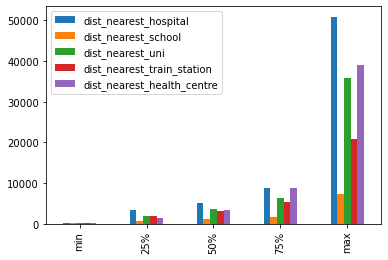

In [17]:
plt.figure(figsize=(15,10))
boston_gdf.describe().iloc[-5:,-10:-5].plot.bar()
plt.show()

<Figure size 1080x720 with 0 Axes>

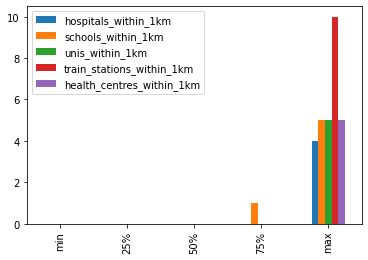

In [18]:
plt.figure(figsize=(15,10))
boston_gdf.describe().iloc[-5:,-5:].plot.bar()
plt.show()

### Seperate explanatory variables from target and split into train and test set (80:20), will be using cross-validation on training set

In [19]:
X = boston_gdf.copy()
y = X.pop('CMEDV')
X.drop("Unnamed: 0", inplace=True, axis=1)
display(X.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

TOWNNO  TRACT        LON        LAT     CRIM    ZN  INDUS  CHAS    NOX  \
0       0   2011 -70.927800  42.426000  0.00632  18.0   2.31     0  0.538   
1       1   2021 -70.919764  42.481455  0.02731   0.0   7.07     0  0.469   
2       1   2022 -70.897264  42.473777  0.02729   0.0   7.07     0  0.469   
3       2   2031 -70.884407  42.490840  0.03237   0.0   2.18     0  0.458   
4       2   2032 -70.874764  42.499371  0.06905   0.0   2.18     0  0.458   

      RM  ...  dist_nearest_hospital  dist_nearest_school  dist_nearest_uni  \
0  6.575  ...           11871.893716          2107.550689       6769.411968   
1  6.421  ...            5512.972788           409.874328       8193.474550   
2  7.185  ...            5274.405874           208.950908       4067.264585   
3  6.998  ...            7944.420665          1584.072245       2474.044561   
4  7.147  ...            7213.393589          1087.155173       5322.710195   

   dist_nearest_train_station  dist_nearest_health_centre  \
0                 5750.495202                 5601.235163   
1                 1035.354223                 4029.846529   
2                 5603.579365                 5989.127609   
3                 5393.198354                 2845.318713   
4                 6482.839009                 4297.399013   

   hospitals_within_1km  schools_within_1km unis_within_1km  \
0                     0                   0               0   
1                     0                   1               0   
2                     0                   1               0   
3                     0                   0               0   
4                     0                   0               0   

   train_stations_within_1km  health_centres_within_1km  
0                          0                          0  
1                          0                          0  
2                          0                          0  
3                          0                          0  
4                          0                          0  

[5 rows x 28 columns]

### Calculate a mutual information score to understand how knowledge of one quantity reduces uncertainty about the target variable

* 0 means that the quantities are independent
* The higher the score the better
* Scores > 2 are uncommon as mutual information score increases slowly as it is a logarithmic quantity

In [20]:
mi_scores = mutual_info_regression(X.loc[:, X.columns != 'geometry'], y, random_state=2021)
mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.loc[:, X.columns != 'geometry'].columns).sort_values(ascending=False)

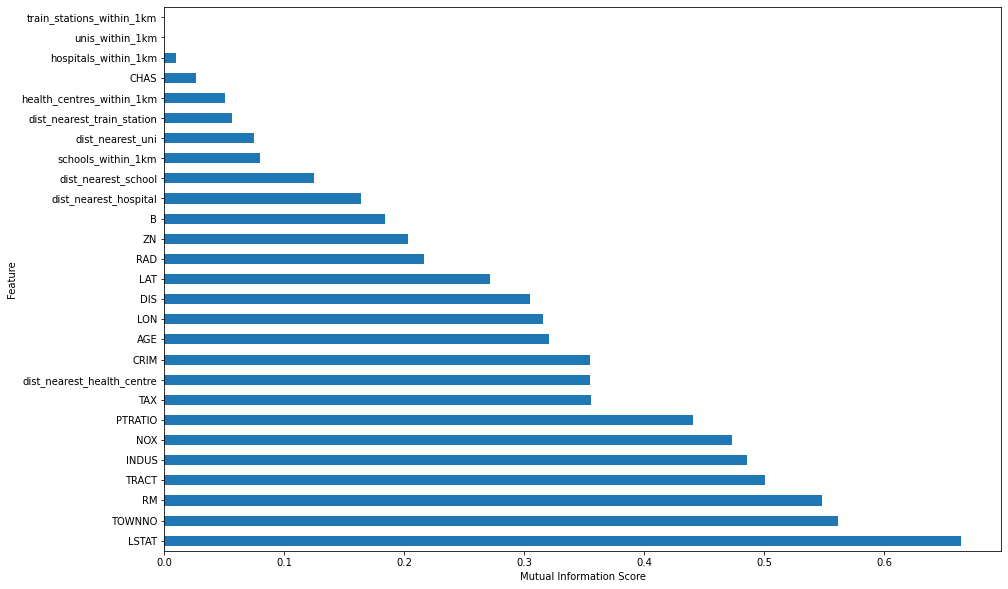

In [21]:
plt.figure(figsize=(15,10))
mi_scores_series.plot.barh()
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

### Correlation coefficients

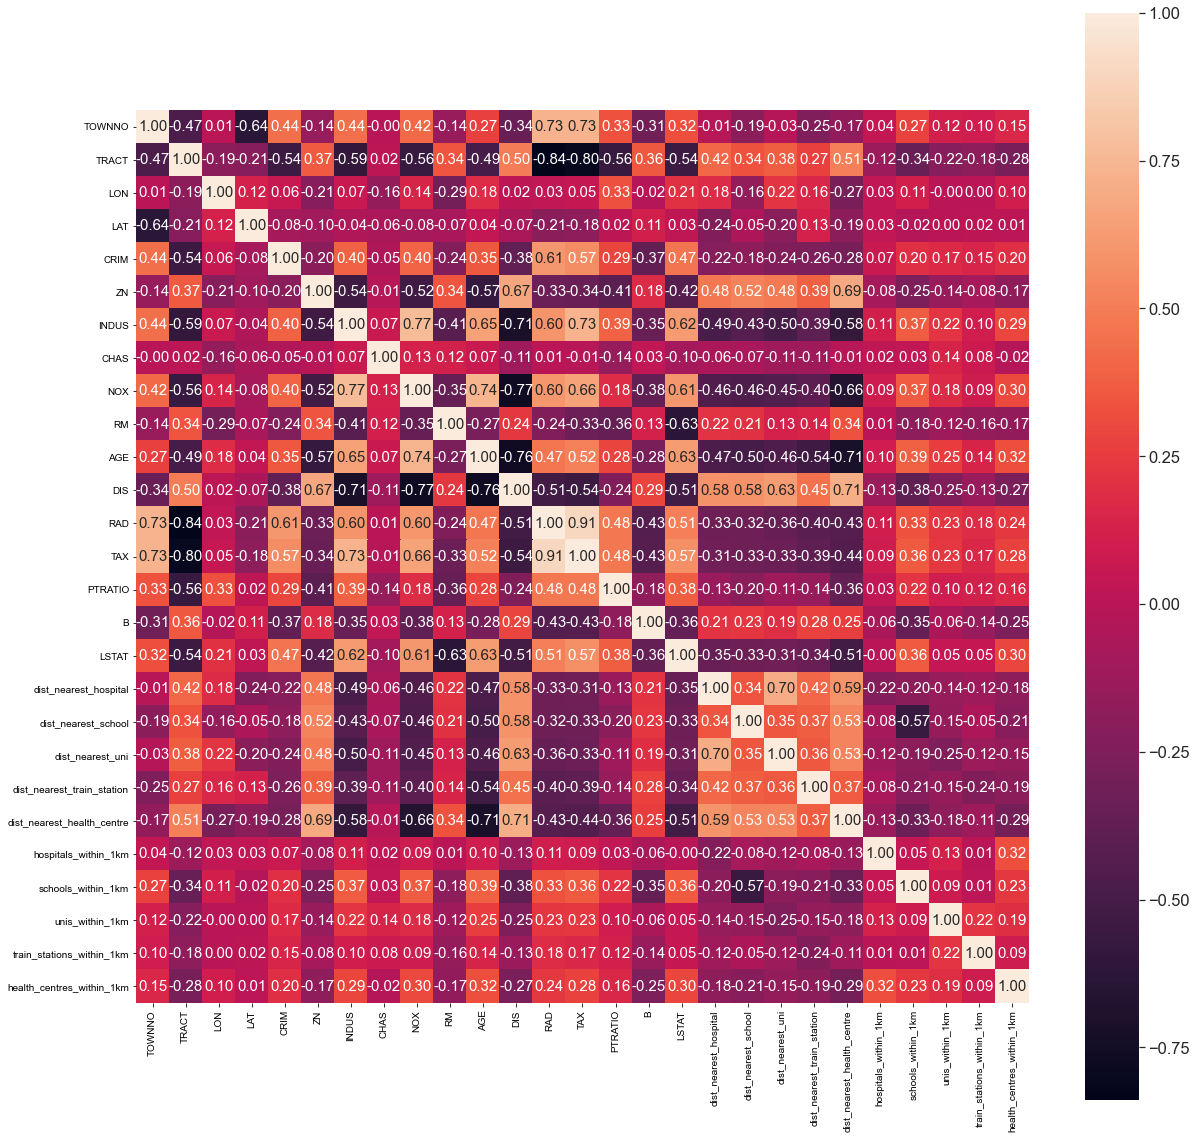

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20,20))
cm = np.corrcoef(X_train.loc[:, X.columns != 'geometry'].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                xticklabels=X_train.loc[:, X.columns != 'geometry'].columns,
                ax=ax)

### Normalizing data using StandardScaler()

In [23]:
x_scaler = StandardScaler()
X_train_sc = x_scaler.fit_transform(X_train.loc[:, X.columns != 'geometry'])
X_test_sc = x_scaler.transform(X_test.loc[:, X.columns != 'geometry'])

### Principle Component Analysis (PCA)

In [24]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_sc)

component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_names)

X_train_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.445404 -1.761237 -2.081877 -0.529034  1.207092  0.014868  0.430123   
1 -0.764400  0.290131 -1.537661 -1.030651  1.114743 -0.094032 -0.593686   
2  5.759925  2.907210  1.416031 -0.830189  0.959315 -0.750220  0.795135   
3 -5.773918  2.325511 -0.568769  1.697332 -2.086151 -0.037210  2.778824   
4 -1.204136 -1.993540 -1.205106 -1.245477 -0.600347  0.081810  0.362309   

        PC8       PC9      PC10  ...      PC18      PC19      PC20      PC21  \
0 -1.232193 -0.557172 -0.195128  ... -0.379178 -0.003391 -0.045612  0.145342   
1 -0.859617  0.176709  0.469387  ...  0.821808 -0.343803  0.269224  0.141854   
2 -1.019795  1.132951  1.509232  ... -0.656947 -0.497440 -1.454207 -0.895395   
3  1.321299  0.907938 -0.995255  ...  0.123393 -0.353376 -0.721172 -0.238734   
4  0.849949  0.524572  0.383087  ... -0.836505  0.012388 -0.842351 -0.255796   

       PC22      PC23      PC24      PC25      PC26      PC27  
0  0.038978 -0.640915  0.155567  0.131529 -0.032744  0.331546  
1 -0.414575  0.806656 -0.131203  0.588079  0.598959  0.079862  
2 -0.058977 -0.714596  0.096943  0.166934 -0.043311  0.437820  
3  0.041304  0.270278 -0.070636  0.008208  0.167699 -0.011867  
4  0.541258  0.553592 -0.302505  0.856875 -0.583684 -0.296931  

[5 rows x 27 columns]

In [25]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train.loc[:, X.columns != 'geometry'].columns,  # and the rows are the original features
)
loadings = pd.concat([loadings, pd.DataFrame(X_train.loc[:, X.columns != 'geometry'].columns, columns=['col_names'], index=X_train.loc[:, X.columns != 'geometry'].columns)], axis=1)

In [26]:
loadings.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
TOWNNO -0.170148  0.446407  0.163332 -0.126050  0.009659  0.037984 -0.175118   
TRACT   0.254174 -0.126348  0.111471 -0.288634  0.071607  0.093921  0.130804   
LON    -0.048362  0.048851 -0.534651 -0.102156  0.232522  0.224722 -0.117678   
LAT     0.002713 -0.389651 -0.281650  0.349088 -0.078145 -0.145626  0.057654   
CRIM   -0.185907  0.217257  0.022757  0.203400 -0.089284 -0.117786  0.081951   

             PC8       PC9      PC10  ...      PC19      PC20      PC21  \
TOWNNO  0.056175 -0.119799  0.031241  ... -0.052300  0.043538 -0.079757   
TRACT   0.275961 -0.072370  0.104712  ...  0.091720 -0.070681  0.132780   
LON    -0.035953  0.009684 -0.214596  ...  0.069267  0.126896 -0.161646   
LAT    -0.334724  0.196073 -0.077362  ...  0.035588  0.107976  0.051017   
CRIM   -0.032296  0.136992 -0.004432  ...  0.259827  0.007391  0.095944   

            PC22      PC23      PC24      PC25      PC26      PC27  col_names  
TOWNNO -0.157760  0.490543 -0.000959  0.265414  0.452723 -0.249040     TOWNNO  
TRACT   0.080597  0.048009 -0.044445 -0.493323  0.160430 -0.540180      TRACT  
LON    -0.122070  0.155523 -0.075911 -0.123822 -0.054580 -0.015868        LON  
LAT    -0.051159  0.248635 -0.024615 -0.023511  0.299334 -0.357623        LAT  
CRIM    0.036600 -0.040001  0.042436  0.022285  0.045444  0.025031       CRIM  

[5 rows x 28 columns]

<BarContainer object of 27 artists>

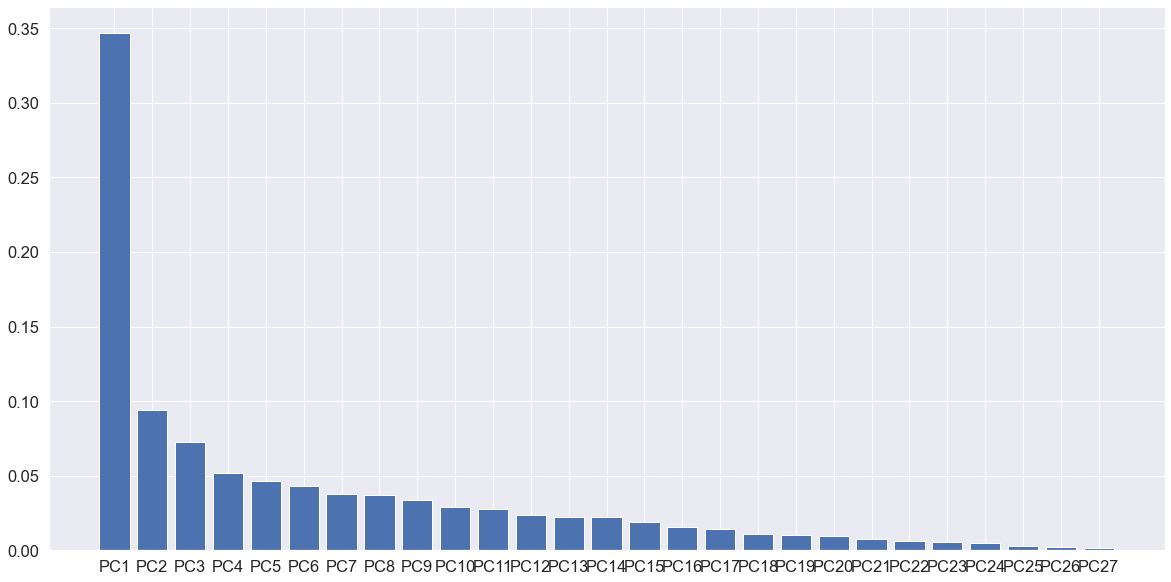

In [27]:
plt.figure(figsize=(20,10))
plt.bar(component_names, pca.explained_variance_ratio_)

<Figure size 4320x2880 with 0 Axes>

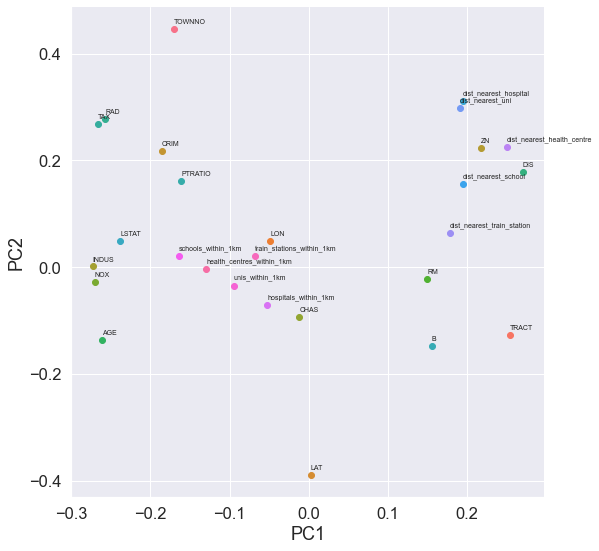

In [28]:
plt.figure(figsize=(60,40))
fg = sns.FacetGrid(data=loadings, hue='col_names', hue_order=X_train.loc[:, X.columns != 'geometry'].columns, height=8)
fg.map(plt.scatter, 'PC1', 'PC2')#.add_legend(ncol=1)
for x, y, label in zip(loadings.PC1, loadings.PC2, loadings.col_names):
    plt.text(x=x, y=y+0.01, s=label, size=7)

### Benchmark model: Linear Regression

In [29]:
def mean_absolute_percentage_error(true, predicted):
    return np.mean(abs((true-predicted)/true))*100

In [30]:
benchmark_model = LinearRegression(n_jobs=-1)
benchmark_model.fit(X_train_sc, y_train)
train_pred = benchmark_model.predict(X_train_sc)
train_RMSE = mean_squared_error(y_train, train_pred, squared=False)
train_MAPE = mean_absolute_percentage_error(y_train, train_pred)
test_pred = benchmark_model.predict(X_test_sc)
test_RMSE = mean_squared_error(y_test, test_pred, squared=False)
test_MAPE = mean_absolute_percentage_error(y_test, test_pred)

In [31]:
benchmark_res = {'train_RMSE':[train_RMSE], 'test_RMSE':[test_RMSE], 'train_MAPE':[train_MAPE], 'test_MAPE':[test_MAPE]}
evaluation = pd.DataFrame(benchmark_res, index=['benchmark'])

In [32]:
evaluation

train_RMSE  test_RMSE  train_MAPE  test_MAPE
benchmark    4.104155    5.76764   15.688544   19.94517

In [33]:
# can try decision tree regressor